In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
%matplotlib inline
import csv

import scipy.optimize as op
import scipy.stats
from scipy.optimize import curve_fit
import scipy.io
from scipy.stats import rice

import random
import pickle
import seaborn as sns

import numpy as np
from scipy.stats import ttest_ind, ttest_ind_from_stats, wilcoxon,ttest_rel, pearsonr,shapiro,f_oneway, ranksums
from scipy.special import stdtr
import csv
import pandas as pd

from scipy.integrate import quad
import sys 
import os
#sys.path.append(os.path.abspath("/Users/neuroimaging/Desktop/MR-code/Python_Code"))

#from ML_UsefulFunctions import *
#from KidneyROIAnalyses import *

from scipy import special

from scipy.integrate import tplquad

pd.options.display.float_format = '{:.3f}'.format

from sklearn.metrics import r2_score


from sklearn.feature_selection import SequentialFeatureSelector

import warnings
warnings.simplefilter("ignore")


from EllipsoidalSimulationCode import *

from statistics import mean

pl.rcParams["font.family"] = "Times New Roman"


def func(x,m,b):
    return m*x + b

In [2]:
fileloc = '/Users/miraliu/Desktop/PostDocCode/Multiexp_Simulations_python/RA_Spectra.xlsx'
Spectra_Data = pd.read_excel(fileloc,sheet_name = 'SpectralPlots') 


def plotmodel(bvals, modelvals):
    return modelvals[0]*np.exp(-bvals*modelvals[4]/1000) + modelvals[1]*np.exp(-bvals*modelvals[5]/1000) + modelvals[2]*np.exp(-bvals*modelvals[6]/1000) + modelvals[3]*np.exp(-bvals*modelvals[7]/1000)
    
def biexp_func(b, frac_fast,frac_slow,diff_fast,diff_slow):
    Data = frac_slow*np.exp(-b*diff_slow)+frac_fast*np.exp(-b*diff_fast)
    normal = frac_slow+frac_fast
    return Data/normal

def monoexp_func(b, frac, diff):
    Data = frac*np.exp(-b*diff)
    return Data



In [7]:
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams["font.family"] = "serif"
pl.rcParams["mathtext.fontset"] = "dejavuserif"

# for the two peak voxel

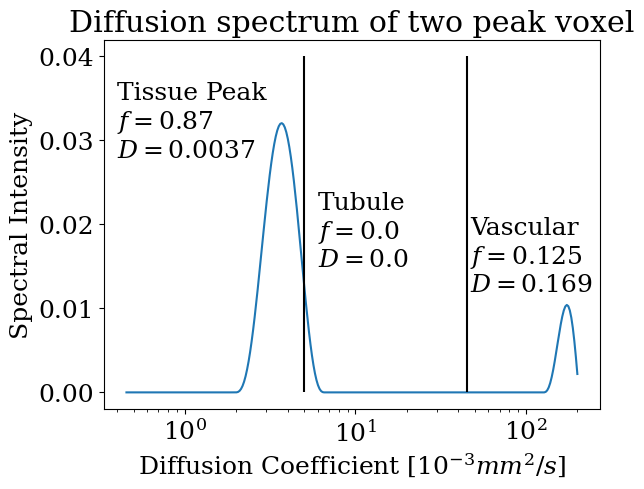

In [57]:
ADCBasisSteps = 300
ADCBasis = np.logspace(np.log10(5), np.log10(2200), ADCBasisSteps)
x = 1/ADCBasis

pl.plot(x*1000,Spectra_Data.iloc[0,10:])
pl.xscale('log', base=10)
pl.vlines(5, 0, .04,color = 'black')
pl.vlines(45, 0, .04, color = 'black')
pl.xlabel('Diffusion Coefficient [$10^{-3} mm^2/s$]')
pl.ylabel('Spectral Intensity')

pl.text(.4,0.028,'Tissue Peak\n$f=0.87$\n$D=0.0037$')
pl.text(6,0.015,'Tubule\n$f=0.0$\n$D=0.0$')
pl.text(47,0.012,'Vascular\n$f=0.125$\n$D=0.169$')
pl.title('Diffusion spectrum of two peak voxel')
pl.show()

pl.show()

In [55]:
bvals = np.array([0, 10, 30, 50, 80, 120, 200, 400, 800])
twopeak_example = [1, 0.836735, 0.77551, 0.744898, 0.663265, 0.520408, 0.469388, 0.153061, 0.0714286]


# fit slow
popt1, pcov = curve_fit(monoexp_func, bvals,twopeak_example,p0=[.7, 0.001],bounds=(0, [1,.1]),maxfev=10000)

#pl.plot(b_values11, monoexp_func(b_values11, popt1[0], popt1[1]))
#pl.scatter(b_values11,df_True.iloc[j,2:-2])
    
# subtract slow fit
popt2, pcov = curve_fit(monoexp_func, bvals,twopeak_example-monoexp_func(bvals,popt1[0], popt1[1]),p0=[.1, 0.01],bounds=(0, [1,.2]),maxfev=10000)

    
 ## order popt from fast to slow diffusion
norm_popt = popt1[0]+popt2[0]
bidiffusions = [popt2[1], popt1[1],]
bifracs=[popt2[0], popt1[0]]/norm_popt
print(bifracs, bidiffusions)


popt, pcov = curve_fit(triexp_func, bvals,twopeak_example,p0=[.1,.2,.7, 0.1, 0.01, 0.001],bounds=(0, [1,1,1,.1,.1,.1]),maxfev=10000)
#pl.scatter(b_values11,triexp_func(b_values11,*popt))
    
## order popt from fast to slow diffusion
norm_popt = popt[0]+popt[1]+popt[2]
idx_sort = popt[3:6].argsort()
fracs = popt[0:3]/norm_popt
diffusions = popt[3:6]
trifracs=fracs[idx_sort[::-1]]
tridiffusions=diffusions[idx_sort[::-1]]
print(trifracs,tridiffusions)



[0.0741371 0.9258629] [0.19999999999999968, 0.004085491817047927]
[0.14287835 0.22127643 0.63584522] [0.1        0.0035811  0.00358075]


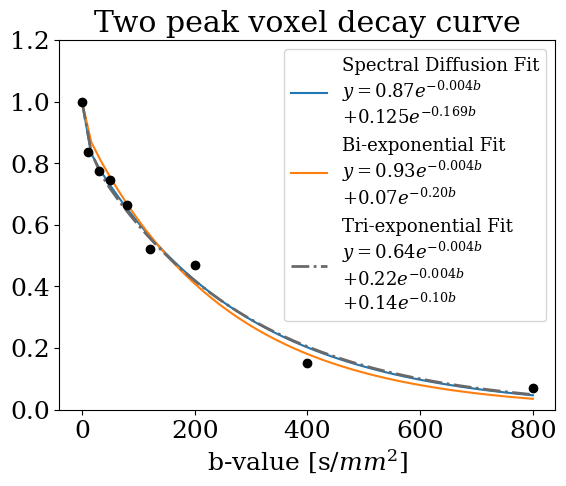

In [56]:


matplotlib.rcParams.update({'font.size': 18})


# plot spectra
twopeakvals = np.array([0.125377321,0,0.874622679,0,169.7648299,0,3.66222323,0])
Extensiveb = np.linspace(0,800,50)
pl.plot(Extensiveb,plotmodel(Extensiveb,twopeakvals),label = 'Spectral Diffusion Fit\n$y=0.87e^{-0.004b}$\n$+0.125e^{-0.169b}$')

# plot bi-exponential
#biexp_fit = biexp_func(Extensiveb, bifracs[0], bifracs[1], bidiffusions[0], bidiffusions[1])
pl.plot(Extensiveb, biexp_func(Extensiveb, bifracs[0], bifracs[1], bidiffusions[0], bidiffusions[1]), label = 'Bi-exponential Fit\n$y=0.93e^{-0.004b}$\n$+ 0.07e^{-0.20b}$')


#plot tri-exponential
pl.plot(Extensiveb, triexp_func(Extensiveb, trifracs[0], trifracs[1], trifracs[2], tridiffusions[0], tridiffusions[1], tridiffusions[2]), label = 'Tri-exponential Fit\n$y=0.64e^{-0.004b}$\n$+ 0.22e^{-0.004b} $\n$+ 0.14e^{-0.10b}$', linestyle = '-.',color = 'dimgrey', linewidth=2)


pl.scatter(bvals, twopeak_example,color = 'black', zorder=3)
pl.title('Two peak voxel decay curve')

pl.xlabel('b-value [s/$mm^2$]')
pl.legend(prop={'size': 13})
pl.ylim(0,1.2)
pl.show()


# for the three peak voxel

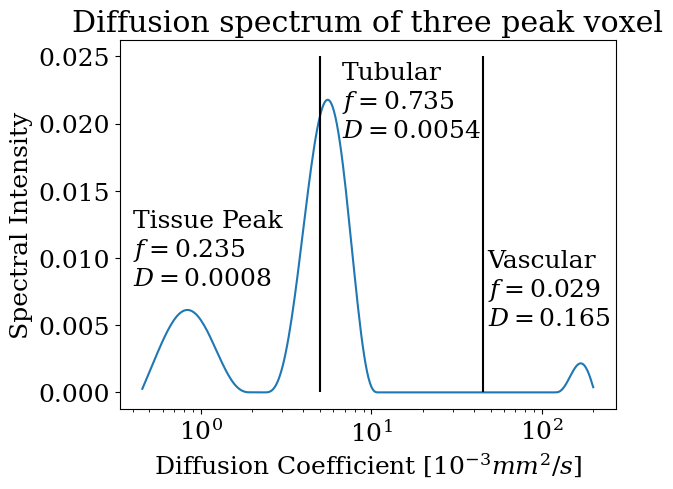

In [58]:
matplotlib.rcParams.update({'font.size': 18})

ADCBasisSteps = 300
ADCBasis = np.logspace(np.log10(5), np.log10(2200), ADCBasisSteps)
x = 1/ADCBasis

pl.plot(x*1000,Spectra_Data.iloc[3,10:])
pl.xscale('log', base=10)
pl.vlines(5, 0, .025,color = 'black')
pl.vlines(45, 0, .025, color = 'black')
pl.xlabel('Diffusion Coefficient [$10^{-3} mm^2/s$]')
pl.ylabel('Spectral Intensity')

pl.text(.4,0.008,'Tissue Peak\n$f=0.235$\n$D=0.0008$')
pl.text(6.7,0.019,'Tubular\n$f=0.735$\n$D=0.0054$')
pl.text(48,0.005,'Vascular\n$f=0.029$\n$D=0.165$')
pl.title('Diffusion spectrum of three peak voxel')
pl.show()

pl.show()

In [34]:
bvals = np.array([0, 10, 30, 50, 80, 120, 200, 400, 800])


threepeak_example = [1, 0.935484, 0.822581, 0.798387, 0.73387, 0.580645, 0.419355, 0.274194, 0.129032]

# fit slow
popt1, pcov = curve_fit(monoexp_func, bvals,threepeak_example,p0=[.7, 0.001],bounds=(0, [1,.1]),maxfev=10000)

#pl.plot(b_values11, monoexp_func(b_values11, popt1[0], popt1[1]))
#pl.scatter(b_values11,df_True.iloc[j,2:-2])
    
# subtract slow fit
popt2, pcov = curve_fit(monoexp_func, bvals,threepeak_example-monoexp_func(bvals,popt1[0], popt1[1]),p0=[.1, 0.01],bounds=(0, [1,.2]),maxfev=10000)

    
 ## order popt from fast to slow diffusion
norm_popt = popt1[0]+popt2[0]
bidiffusions = [popt2[1], popt1[1],]
bifracs=[popt2[0], popt1[0]]/norm_popt
print(bifracs,bidiffusions)


popt, pcov = curve_fit(triexp_func, bvals,threepeak_example,p0=[.1,.2,.7, 0.1, 0.01, 0.001],bounds=(0, [1,1,1,.1,.1,.1]),maxfev=10000)
#pl.scatter(b_values11,triexp_func(b_values11,*popt))
    
## order popt from fast to slow diffusion
norm_popt = popt[0]+popt[1]+popt[2]
idx_sort = popt[3:6].argsort()
fracs = popt[0:3]/norm_popt
diffusions = popt[3:6]
trifracs=fracs[idx_sort[::-1]]
tridiffusions=diffusions[idx_sort[::-1]]
print(trifracs,tridiffusions)


[0.04425735 0.95574265] [0.16301723181953354, 0.0035843827110083595]
[0.0332674  0.68049107 0.28624153] [0.1        0.00577143 0.00102446]


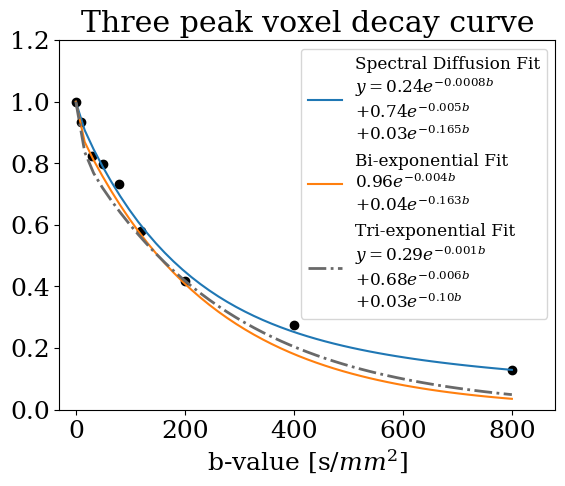

In [59]:
matplotlib.rcParams.update({'font.size': 18})

pl.scatter(bvals, threepeak_example,color = 'black')

# plot spectra
threepeakvals = np.array([0.029455024,0.735569858,0.234975117,0,165.2977017,5.398931783,0.84571726,0])
Extensiveb = np.linspace(0,800,50)
pl.plot(Extensiveb,plotmodel(Extensiveb,threepeakvals),label = 'Spectral Diffusion Fit\n$y=0.24e^{-0.0008b}$\n$+ 0.74e^{-0.005b} $\n$+ 0.03e^{-0.165b}$')

# plot bi-exponential
#biexp_fit = biexp_func(Extensiveb, bifracs[0], bifracs[1], bidiffusions[0], bidiffusions[1])
pl.plot(Extensiveb, biexp_func(Extensiveb, bifracs[0], bifracs[1], bidiffusions[0], bidiffusions[1]), label = 'Bi-exponential Fit\n$0.96e^{-0.004b}$\n$+ 0.04e^{-0.163b}$')


#plot tri-exponential
pl.plot(Extensiveb, triexp_func(Extensiveb, trifracs[0], trifracs[1], trifracs[2], tridiffusions[0], tridiffusions[1], tridiffusions[2]), label = 'Tri-exponential Fit\n$y=0.29e^{-0.001b}$\n$+ 0.68e^{-0.006b} $\n$+ 0.03e^{-0.10b}$', linestyle = '-.',color = 'dimgrey', linewidth=2)
pl.xlabel('b-value [s/$mm^2$]')
pl.title('Three peak voxel decay curve')
pl.xlim(-30,880)
pl.legend(prop={'size': 12.2})
pl.ylim(0,1.2)
pl.show()
